In [232]:
# import numpy as np
# import matplotlib.pyplot as plt
# import sklearn
# from numba import jit

# visual_drift_coef = 1.2
# visual_drift_min = 0.8
# memory_drift_coef = 0.7
# memory_drift_adaptive_coef = 0
# visual_drift_adaptive_coef = 0

In [233]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from numba import jit
from matplotlib_scalebar.scalebar import ScaleBar
path_figs = 'Figs/'

visual_drift_coef = 1
visual_drift_min = 0.8
memory_drift_coef = 0.3
memory_drift_adaptive_coef = 0
visual_drift_adaptive_coef = 0
memory_drift_adaptive_coef_activation = 0.3
memory_drift_adaptive_coef_deactivation = 0.9

In [234]:
def calc_visual_drifts(seq, seq_length):
    seq_fingers = np.array([int(_) for _ in seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result



In [235]:
def calc_memory_drifts(specific_seq, seq_length):
    seq_fingers = np.array([int(_) for _ in specific_seq]) - 1
    result = np.zeros((5, seq_length))

    result[seq_fingers, np.arange(seq_length)] = 1


    return result

In [254]:
# seq = '13524232514111'
# specific_seq = '13524232514111'
# random_seq = '45341323141322'
# specific_seq_changed = '13524223141322'
# specific_seq_changed_one_digit = '13524212514111'

seq = '13524232514'
specific_seq = '13524232514'
random_seq = '45341323141'
specific_seq_changed = '13524213333'
specific_seq_changed_one_digit = '13524212514'


seq_length = len(seq)

# window_sizes = [1,2,3,4,11]
window_sizes = [2,3,4,11]


visual_drifts = calc_visual_drifts(seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

# drifts = np.array([1,1,1,1,2]).reshape(5, 1)
# drifts = np.repeat(drifts, seq_length , axis = 1)

visual_delay = 90
motor_delay = 50

diffusion = 2
threshold = 350
alpha = 0.9985
beta = 0.0005

# param = [0.80456878, 0.36385731, 0.75921864, 0.36382248, 0.17006857,
#        0.72666298, 0.36340774, 0.16293408, 0.07705195]


# param = [0.81403939, 0.39269762, 0.78576587, 0.39263559, 0.1590846 ,
#        0.78171855, 0.39182347, 0.13888817, 0.05866263]


# param = [0.80546286, 0.34406671, 0.77078511, 0.34047097, 0.17400204,
#        0.76927114, 0.33807873, 0.16315422, 0.08028436]


# param = [0.75295921, 0.50182646, 0.73406735, 0.45987093, 0.34447993,
#         0.69723121, 0.41742494, 0.2493258 , 0.24174475]


param = [0.782587,  0.4290474,  0.7447472,  0.4274116,  0.31541915]


# motor_planning_param = [0.54899844, 0.3728446 , 0.32852511]
motor_planning_param = [0.7527961,  0.78437558, 0.16115195]
motor_planning_param = [0.78642621, 0.78482953, 0.16115546]

In [255]:
visual_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [256]:
memory_drifts

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.]])

In [257]:
@jit(nopython=True)
def get_planning_coefs(strategy, capacity, param):
    if strategy == 0:
        return exp_normalized_planning_jit(capacity, param)
    elif strategy == 1:
        return inv_normalized_planning_jit(capacity)
    else:
        raise ValueError("Unknown strategy")


@jit(nopython=True)
def exp_normalized_planning_jit(capacity, param):
    theta = np.zeros(capacity)
    
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = param[1]
    elif capacity >= 3:
        theta[0] = param[2]
        theta[1] = param[3]
        theta[2] = param[4]

    return theta
    

@jit(nopython=True)
def inv_normalized_planning_jit(capacity):
    x = np.arange(capacity)
    theta = 1 / (x + 1)
    # theta /= np.sum(theta)
    return theta

In [258]:
@jit(nopython=True)
def exp_motor_planning(capacity, param):
    theta = np.zeros(capacity)
    if capacity == 0:
        return theta
    if capacity == 1:
        theta[0] = 1
    elif capacity == 2:
        theta[0] = param[0]
        theta[1] = 1 - theta[0]
    elif capacity >= 3:
        theta[0] = param[1]
        theta[1] = param[2]
        theta[2] = 1 - theta[0] - theta[1]
    # elif capacity >= 4:
    #     theta[0] = param[3]
    #     theta[1] = param[4]
    #     theta[2] = param[5]
    #     theta[3] = 1 - theta[0] - theta[1] - theta[2]
        
    return theta

In [259]:
def check_evidence_to_seq(evidence, seq):
    for press in range(len(seq)):
        if ~(np.argmax(evidence[:, press]) + 1 == int(seq[press])):
            return False
    return True

In [260]:
def calculate_IPI_from_press_time(press_times):

   return np.array([press_times[0]] + [press_times[i] - press_times[i-1] for i in range(1, len(press_times))])

In [261]:
@jit(nopython=True)
def simulate_ddm(seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt, max_time, 
                 seq_length, window_size, planning_capacity, planning_param, motor_planning_param , planning_strategy, visual_delay, motor_delay, alpha, beta, memory_drift_coef):
    evidence = np.zeros((5, seq_length))
    time = 0
    visual_delay_queue = np.zeros(min(window_size, seq_length), dtype=float)
    motor_delay_queue = np.zeros(0, dtype=float)
    current_press_planned = 0
    current_press_execed = 0

    current_memory_coef = memory_drift_coef
    current_visual_coef = visual_drift_coef

    effective_planning_capacity = 0
    effective_planning_capacity_motor = 0
    visible_window_size = 0

    planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
    motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




    sqrt_dt = np.sqrt(dt)
    drifts_visual_dt = visual_drifts * dt
    drifts_memory_dt = memory_drifts * dt
    diffusion_term = diffusion * sqrt_dt

    total_steps = int(max_time / dt)
    random_terms = np.random.randn(5, seq_length, total_steps)
    random_terms_memory = np.random.rand(5, total_steps)

    t_index = 0

    press_times = np.full(seq_length, np.nan)
    A = np.eye(5) * alpha - np.full((5,5), beta) + np.eye(5) * beta


    while time < max_time - dt:
        time += dt
        visual_delay_queue += dt
        if len(motor_delay_queue) > 0:
            motor_delay_queue[0] += dt
        t_index += 1

        evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
        evidence[:, current_press_planned:] += diffusion_term * random_terms[:, current_press_planned:, t_index]

        for press in range(current_press_planned, min(current_press_planned + visible_window_size, seq_length, current_press_planned + effective_planning_capacity)):
            evidence[:, press] += planning_coefs[press - current_press_planned] * drifts_visual_dt[:, press] * current_visual_coef

        for press in range(current_press_planned, min(seq_length, current_press_planned + effective_planning_capacity_motor)):
            evidence[:, press] += motor_planning_coefs[press - current_press_planned] * drifts_memory_dt[:, press] * current_memory_coef
            

        evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])
            


        if (evidence[:, current_press_planned: current_press_planned + 1] >= threshold).any():
            visible_window_size -= 1
            current_press_planned += 1
            motor_delay_queue = np.append(motor_delay_queue, 0)
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = min(seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




        if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= motor_delay:
            motor_delay_queue = motor_delay_queue[1:]
            visual_delay_queue = np.append(visual_delay_queue, 0)
            press_times[current_press_execed] = time

            if seq[current_press_execed] == specific_seq[current_press_execed]:
                current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef_activation
                current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
            else:
                current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef_deactivation
                current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef

            current_press_execed += 1
            
            if current_press_execed == seq_length:
                break   

        visual_delay_passed_mask = (visual_delay_queue >= visual_delay)
        pass_count = sum(visual_delay_passed_mask)
        if pass_count > 0:
            visible_window_size += pass_count
            visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
            effective_planning_capacity = min(visible_window_size, seq_length - current_press_planned, planning_capacity)
            effective_planning_capacity_motor = min(seq_length - current_press_planned, planning_capacity)
            planning_coefs = get_planning_coefs(planning_strategy, effective_planning_capacity, planning_param)
            motor_planning_coefs = exp_motor_planning(effective_planning_capacity_motor, motor_planning_param)




    return press_times, evidence

In [262]:
class DriftDiffusionModel_Optimzied:
    def __init__(self, seq, specific_seq, visual_drifts, memory_drifts, diffusion, threshold, dt = 1, max_time = 10000,  #todo: when changing dt, the round(time, 2) should be changed according to the precision of dt
                 seq_length = 11, window_size = 2, planning_capacity = 3, planning_param = 3, motor_planning_param = 3, 
                 planning_strategy = 0, visual_delay = visual_delay, motor_delay = motor_delay,  alpha = 0.995, beta = 0.001, memory_drift_coef = 0.7): #todo: consider having different diffusions for different fingers (e.g. should we have different one when interference happens?)
        """
        Initialize the Drift-Diffusion Model.

        Parameters:
        drifts (list of float): List of drift rates for each process.
        diffusion (float): Diffusion coefficient (assumed to be the same for all processes).
        threshold (float): Decision threshold.
        dt (float): Time step for the discrete-time simulation.
        max_time (float): Maximum simulation time to prevent infinite loops.
        """
        self.seq_length = seq_length
        self.presses = [None for _ in range(seq_length)]
        self.window_size = window_size
        assert visual_drifts.shape == (5,seq_length), "There must be exactly 5 drift rates."
        self.visual_drifts = visual_drifts 
        self.memory_drifts = memory_drifts
        self.diffusion = diffusion
        self.threshold = threshold
        self.dt = dt
        self.max_time = max_time
        self.planning_strategy = planning_strategy
        self.planning_capacity = planning_capacity
        self.planning_param = planning_param
        self.motor_planning_param = motor_planning_param
        self.press_times = [None for _ in range(seq_length)]
        self.visual_delay = visual_delay
        self.motor_delay = motor_delay
        self.seq = seq
        self.specific_seq = specific_seq
        self.alpha = alpha
        self.beta = beta

        self.memory_drifts_coef = memory_drift_coef
    

    def simulate(self):
        press_times, evidence = simulate_ddm(self.seq, self.specific_seq, self.visual_drifts, self.memory_drifts,
                                              self.diffusion, self.threshold, self.dt, self.max_time, self.seq_length, 
                                              self.window_size, self.planning_capacity, self.planning_param, self.motor_planning_param,
                                              self.planning_strategy, self.visual_delay, self.motor_delay, self.alpha, self.beta, self.memory_drifts_coef)
        self.press_times = press_times
        return calculate_IPI_from_press_time(self.press_times), evidence
    


    def plot_IPIs(self):
        plt.plot(range(self.seq_length), calculate_IPI_from_press_time(self.press_times))
        plt.show()
                
    
    
    def plot_simulations(self):
        """
        Plot the evidence accumulation for the specified number of simulations.

        Parameters:
        num_simulations (int): Number of simulations to plot.
        """ 
        
        fig, axs = plt.subplots(self.seq_length, figsize=(15,20))
        evidence = np.zeros((5, self.seq_length))
        evidence_over_time = np.zeros((5, self.seq_length, int(self.max_time/self.dt)))
        time = 0
        t_index = 0
        visual_delay_queue = np.array([0] * min(self.window_size, self.seq_length), dtype=float)
        motor_delay_queue = np.array([], dtype=float)
        current_press_planned = 0
        current_press_execed = 0

        current_memory_coef = memory_drift_coef
        current_visual_coef = visual_drift_coef

        effective_planning_capacity = 0
        planning_coefs = get_planning_coefs(strategy= self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
        motor_planning_coefs = planning_coefs / sum(planning_coefs)
        visible_window_size = 0

        press_times = np.full(seq_length, np.nan)
        A = np.eye(5) * self.alpha - np.full((5,5), beta) + np.eye(5) * beta

        total_steps = int(self.max_time / self.dt)

        random_terms = np.random.randn(5, seq_length ,total_steps)
        # visual_delay_passed = False

        while time < self.max_time - self.dt:
            time += self.dt
            t_index += 1
            visual_delay_queue += self.dt
            if len(motor_delay_queue) > 0:
                motor_delay_queue[0] += self.dt
            # current_press_time += self.dt


            evidence[:, current_press_planned: ] = A @ evidence[:, current_press_planned: ]
            evidence[:, current_press_planned:] += self.diffusion * np.sqrt(self.dt) * random_terms[:, current_press_planned:, t_index]
            evidence_over_time[:, current_press_planned: ,t_index] = evidence[:, current_press_planned:]

            for press in range(current_press_planned, min(current_press_planned + visible_window_size, self.seq_length,current_press_planned + effective_planning_capacity)):
                for finger in range(5):
                    # evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt + self.diffusion * np.sqrt(self.dt) * np.random.randn()
                    evidence[finger, press] += planning_coefs[press - current_press_planned] * self.visual_drifts[finger, press] * self.dt * current_visual_coef 
                    evidence[finger, press] += motor_planning_coefs[press - current_press_planned] * self.memory_drifts[finger, press] * self.dt * current_memory_coef
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

                # if press == current_press_planned:
                #         for finger in range(5):
                #             evidence[finger, current_press_planned] += self.memory_drifts[finger, current_press_planned] * self.dt * current_memory_coef
                #             evidence_over_time[finger, current_press_planned, t_index] = evidence[finger, current_press_planned]

            for press in range(0, current_press_planned):
                for finger in range(5):
                    evidence_over_time[finger, press, t_index] = evidence[finger, press]

            evidence[:, current_press_planned: ] = np.maximum(0, evidence[:, current_press_planned: ])


            if (evidence[: , current_press_planned:min(current_press_planned + visible_window_size, self.seq_length, current_press_planned + effective_planning_capacity)] >= self.threshold).any():
                # press_times[current_press_planned] = time
                # visual_delay_passed = False
                visible_window_size -= 1
                
                # if self.seq[current_press_planned] == self.specific_seq[current_press_planned]:
                #     current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                #     current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                # else:
                #     current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                #     current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef


                current_press_planned += 1
                motor_delay_queue = np.append(motor_delay_queue, 0)
                # visual_delay_queue = np.append(visual_delay_queue, 0)
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy=self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param)
                motor_planning_coefs = planning_coefs / sum(planning_coefs)
            
            if len(motor_delay_queue) > 0 and motor_delay_queue[0] >= self.motor_delay:
                motor_delay_queue = motor_delay_queue[1:]
                visual_delay_queue = np.append(visual_delay_queue, 0)
                press_times[current_press_execed] = time

                if self.seq[current_press_execed] == self.specific_seq[current_press_execed]:
                    current_memory_coef += (memory_drift_coef - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_min - current_visual_coef) * visual_drift_adaptive_coef
                else:
                    current_memory_coef += (0 - current_memory_coef) * memory_drift_adaptive_coef
                    current_visual_coef += (visual_drift_coef - current_visual_coef) * visual_drift_adaptive_coef
                print("current memory: ", current_memory_coef)
                print("current vision: ", current_visual_coef)

                current_press_execed += 1

                if current_press_planned == self.seq_length:
                    break

            visual_delay_passed_mask = (visual_delay_queue >= self.visual_delay)
            pass_count = sum(visual_delay_passed_mask)
            if pass_count > 0:
                visible_window_size += pass_count
                visual_delay_queue = visual_delay_queue[~visual_delay_passed_mask]
                effective_planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
                planning_coefs = get_planning_coefs(strategy = self.planning_strategy, capacity = effective_planning_capacity, param = self.planning_param) 
                motor_planning_coefs = planning_coefs / sum(planning_coefs)

            
            # if current_press_time >= self.visual_delay:
            #     if ~visual_delay_passed:
            #         visual_delay_passed = True
            #         visible_window_size = self.window_size
            #         planning_capacity = min(visible_window_size, self.seq_length - current_press_planned, self.planning_capacity)
            #         planning_coefs = self.planning_strategy(capacity = planning_capacity)
                    

        for press in range(self.seq_length):
            for finger in range(5):
                axs[press].plot(np.arange(0, np.round(time, 2), self.dt), evidence_over_time[finger, press, :t_index], label = f'Finger {finger+1}')
            axs[press].set_xlim([0, np.round(time, 2)])
            axs[press].axhline(y = self.threshold, color = 'r', linestyle = '--', label = 'Threshold')
            axs[press].set_xlabel('Time')
            axs[press].axvline(x = press_times[press], color = 'b', linestyle = '--', label = 'hit')
            # axs[press].set_ylabel('Evidence')
            axs[press].set_xticks(np.append(axs[press].get_xticks(), press_times[press]))

            axs[press].set_title(f'Press {press + 1}')

        fig.supylabel('Evidence')

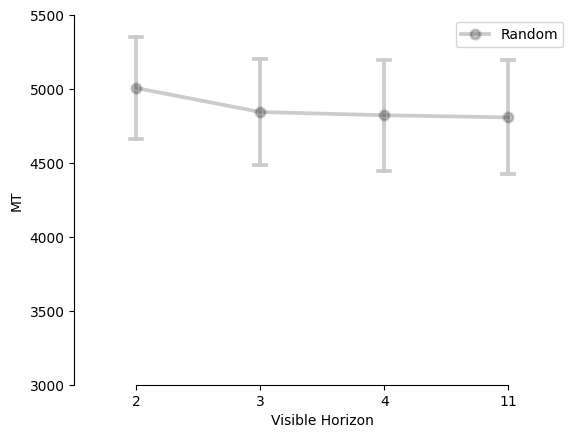

CPU times: user 10.6 s, sys: 132 ms, total: 10.7 s
Wall time: 10.9 s


In [33]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

num_sims = 200

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = 'Random', capsize=0.1, **kwargs[label])




plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')
plt.ylim([3000, 5500])

# legend labels

plt.legend(loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_Random_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()


### Fitting motor planning params:

Try unfixed capacity for motor as well

In [224]:
def check_motor_param_condition(params):
    
    if params[0] < 1 - params[0]:
        return False
    
    if params[1] < params[2]:
        return False
    
    if params[2] < 1 - params[1] - params[2]:
        return False
    
    if params[1] + params[2] > 1:
        return False
    

    else:
        return True

In [225]:
num_sims = 1000

visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

In [226]:
MTs_random = MT.groupby('windowSize').agg({
    'MT' : 'mean'
}).reset_index()

In [227]:
np.cov(MTs_random['MT'], MTs_random['MT'] /2 - 5)[0,1] / np.var( MTs_random['MT'], ddof = 1)

0.5

In [228]:
window_sizes

[2, 3, 4, 11]

In [229]:
from pyswarm import pso

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

def loss(motor_params, MTs_random):
    if not check_motor_param_condition(motor_params):
        return np.inf
    else:
        MT = pd.DataFrame(columns = ['windowSize', 'MT'])  
        n_sims = 200 
        
        for window in window_sizes:
            model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
                threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
                motor_planning_param = motor_params, alpha = alpha , beta = beta, 
                seq_length = seq_length, memory_drift_coef = memory_drift_coef)
            for _ in range(n_sims):
                IPIs, evidence = model.simulate()
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

        MTs_trained = MT.groupby('windowSize').agg({
                'MT' : 'mean'
            }).reset_index()
        
        return (np.cov(MTs_random['MT'], MTs_trained['MT'])[0,1] / np.var( MTs_random['MT'], ddof = 1) - 1) ** 2
            
    

def optimize(MTs_random):

    lb = np.zeros(3)
    ub = np.ones(3)
    
    params_opt, loss_opt = pso(loss, lb, ub, args=(MTs_random,), maxiter=20, swarmsize=10000, debug=True)
    
    return params_opt, loss_opt

In [230]:
optimize(MTs_random)

No constraints given.
New best for swarm at iteration 1: [1. 1. 0.] 0.011179428954509288
New best for swarm at iteration 1: [1. 1. 0.] 0.007940440929960976
Stopping search: Swarm best position change less than 1e-08


(array([1., 1., 0.]), 0.007940440929960976)

In [250]:
from scipy.optimize import fmin

from pyswarm import pso

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)

def loss(motor_params, MTs_random):
    if not check_motor_param_condition(motor_params):
        return np.inf
    else:
        MT = pd.DataFrame(columns = ['windowSize', 'MT'])  
        n_sims = 200 
        
        for window in window_sizes:
            model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
                threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
                motor_planning_param = motor_params, alpha = alpha , beta = beta, 
                seq_length = seq_length, memory_drift_coef = memory_drift_coef)
            for _ in range(n_sims):
                IPIs, evidence = model.simulate()
                MT.loc[len(MT)] = [window, sum(IPIs[1:])]

        MTs_trained = MT.groupby('windowSize').agg({
                'MT' : 'mean'
            }).reset_index()
        
        return (np.cov(MTs_random['MT'], MTs_trained['MT'])[0,1] / np.var( MTs_random['MT'], ddof = 1) - 1) ** 2
            

    

def optimize(MTs_random):
    res = fmin(loss, motor_planning_param, args = (MTs_random,), maxiter=1000)
    
    return res

In [252]:
optimize(MTs_random)

/var/folders/wg/16zn32014z5grhdv06dk49f00000gn/T/ipykernel_45352/478945167.py:35: RuntimeWarning: Maximum number of iterations has been exceeded.
  res = fmin(loss, motor_planning_param, args = (MTs_random,), maxiter=1000)


array([0.78642621, 0.78482953, 0.16115546])

In [253]:
motor_planning_param

[0.7527961, 0.78437558, 0.16115195]

<timed exec>:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


                                  sum_sq      df             F        PR(>F)
C(windowSize)               1.427465e+07     3.0     61.484183  1.305023e-37
C(condition)                1.109728e+09     1.0  14339.554288  0.000000e+00
C(windowSize):C(condition)  9.555642e+05     3.0      4.115834  6.411948e-03
Residual                    1.232037e+08  1592.0           NaN           NaN
                            MT
condition windowSize          
rand      2.0         4979.620
          3.0         4863.695
          4.0         4817.510
          11.0        4795.180
unchanged 2.0         3394.785
          3.0         3187.150
          4.0         3101.655
          11.0        3109.900


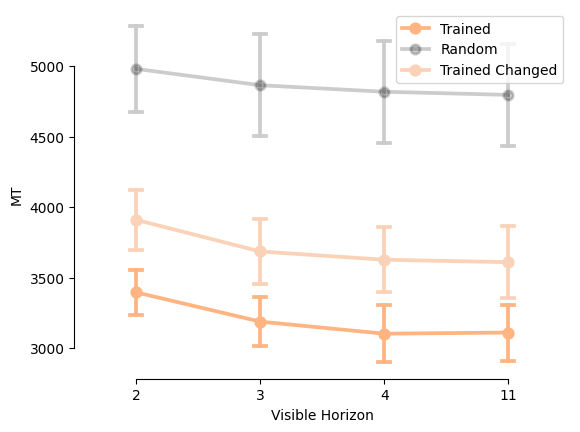

CPU times: user 33.7 s, sys: 1.2 s, total: 34.9 s
Wall time: 34.1 s


In [265]:
%%time 
import statsmodels.api as sm
from statsmodels.formula.api import ols

trained_pallet = sns.light_palette(sns.color_palette('pastel')[1], n_colors=3)
kwargs = {'changed': {'color': trained_pallet[1] , 'alpha': 1}, 'unchanged': {'color': trained_pallet[2], 'alpha': 1}, 'rand': {'color': 'black', 'alpha': 0.2}}

ANOVA_data = pd.DataFrame(columns = ['MT', 'windowSize', 'condition'])

visual_drifts = calc_visual_drifts(specific_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'unchanged'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
num_sims = 200
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(seq, specific_seq, visual_drifts, memory_drifts, diffusion, 
    threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, planning_param=param,
    motor_planning_param = motor_planning_param, alpha = alpha , beta = beta, 
    seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])


visual_drifts = calc_visual_drifts(random_seq, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
label = 'rand'
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(random_seq, specific_seq,  visual_drifts, np.zeros((5, seq_length)), 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param,alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]



sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])

ANOVA_data = pd.concat([ANOVA_data, MT.assign(condition = label)])




visual_drifts = calc_visual_drifts(specific_seq_changed_one_digit, seq_length)
memory_drifts = calc_memory_drifts(specific_seq, seq_length)
MT = pd.DataFrame(columns = ['windowSize', 'MT'])
label = 'changed'
for window in window_sizes:
    model = DriftDiffusionModel_Optimzied(specific_seq_changed_one_digit, specific_seq, visual_drifts, memory_drifts, 
    diffusion, threshold, window_size=window, visual_delay=visual_delay, motor_delay = motor_delay, planning_capacity=3, 
    planning_param=param, motor_planning_param = motor_planning_param, 
    alpha = alpha, beta = beta, seq_length = seq_length, memory_drift_coef = memory_drift_coef)
    for _ in range(num_sims):
        IPIs, evidence = model.simulate()
        MT.loc[len(MT)] = [window, sum(IPIs[1:])]

sns.pointplot(data=MT, x='windowSize', y='MT', errorbar='sd', dodge=True, label = label, capsize=0.1, **kwargs[label])


model = ols('MT ~ C(windowSize) + C(condition) + C(windowSize):C(condition)', data=ANOVA_data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
print(ANOVA_data.groupby(['condition', 'windowSize']).agg({'MT': 'mean'}))


plt.xticks(range(len(window_sizes)), window_sizes)
plt.xlabel('Visible Horizon')
plt.ylabel('MT')

# legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = ['Trained', 'Random', 'Trained Changed']
plt.legend(handles, labels, loc='upper right')

# plt.legend()
sns.despine(trim=True)
# plt.savefig(path_figs + "MT_test_digi_capacity_expansion.pdf", format = 'pdf', bbox_inches = 'tight')
plt.show()
